# CIC IDS DATASET 2017

THIS IS THE WORK DONE BY SIA DHAMA(230103009) ON THE IDS INTRUSION DETECTION DATASET IN 2017
https://www.unb.ca/cic/datasets/ids-2017.html

# IMPORTING LIBRARIES


In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import scipy
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# LOADING DATA ,PREPROCESSING AND CLEANING



In [ ]:
import kagglehub
# Download latest version
dataset_path = kagglehub.dataset_download("dhoogla/cicids2017")
print("Path to dataset files:", dataset_path)

100%|██████████| 227M/227M [00:02<00:00, 86.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3


In [ ]:
#join all the dataframes into one
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.parquet')]
df = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)

In [ ]:
#checking the shape of df and other info
print("Original dataset shape:", df.shape)
print(df.info())
print(df.head())
print(df.describe())

#checking for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Original dataset shape: (2313810, 78)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313810 entries, 0 to 2313809
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int32  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  int32  
 5   Bwd Packets Length Total  int32  
 6   Fwd Packet Length Max     int16  
 7   Fwd Packet Length Min     int16  
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     int16  
 11  Bwd Packet Length Min     int16  
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              int32  
 19  Flow IAT Min             

In [ ]:
#checking the shape of df and other info
print("Original dataset shape:", df.shape)
print(df.info())
print(df.head())
print(df.describe())


Original dataset shape: (2313810, 78)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313810 entries, 0 to 2313809
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int32  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  int32  
 5   Bwd Packets Length Total  int32  
 6   Fwd Packet Length Max     int16  
 7   Fwd Packet Length Min     int16  
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     int16  
 11  Bwd Packet Length Min     int16  
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              int32  
 19  Flow IAT Min             

In [ ]:
print(df['Label'].unique())
df['Label'].value_counts()
# duplicates,missing and infinity values
# df = df.drop(df[pd.isnull(df['Flow ID'])].index) # Removed this line
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
print(df.shape)

['Benign' 'Bot' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'DDoS' 'Infiltration' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'FTP-Patator'
 'SSH-Patator' 'PortScan']
(2313810, 78)


In [ ]:
#label encoding
from collections import Counter
# original labels
y = df['Label']
# set threshold for "rare" classes
threshold = 100   # you can tune this (<= 100 samples → merge)
counts = Counter(y)
# group rare classes into "OtherAttack"
y_grouped = y.apply(lambda x: x if counts[x] >= threshold else "OtherAttack")
print("Original counts:\n", pd.Series(y).value_counts())
print("\nAfter grouping:\n", pd.Series(y_grouped).value_counts())

Original counts:
 Label
Benign                        1977318
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

After grouping:
 Label
Benign                      1977318
DoS Hulk                     172846
DDoS                         128014
DoS GoldenEye                 10286
FTP-Patator                    5931
DoS slowloris                  5385
DoS Slowhttptest               5228
SSH-Patator                    3219
PortScan                       1956
Web Attack � Brute Force       1

In [ ]:
#creating the input and output features
X = df.drop(columns=['Label'])
y = y_grouped
# drop non numeric data types with labels
drop_cols = [c for c in ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'] if c in X.columns]
X = X.drop(columns=drop_cols, errors='ignore')


In [ ]:
import pandas as pd

# Assuming y is your label column (Series or list)
label_percentages = (y.value_counts(normalize=True) * 100).round(2)

print("Percentage of each label:\n")
print(label_percentages)


Percentage of each label:

Label
Benign                      85.46
DoS Hulk                     7.47
DDoS                         5.53
DoS GoldenEye                0.44
FTP-Patator                  0.26
DoS slowloris                0.23
DoS Slowhttptest             0.23
SSH-Patator                  0.14
PortScan                     0.08
Web Attack � Brute Force     0.06
Bot                          0.06
Web Attack � XSS             0.03
OtherAttack                  0.00
Name: proportion, dtype: float64


In [ ]:
import pandas as pd

label_percentages = (y.value_counts(normalize=True) * 100).round(2)
label_df = label_percentages.reset_index()
label_df.columns = ['Label', 'Percentage']
label_df = label_df.sort_values(by='Percentage', ascending=False)

print(label_df.to_string(index=False))


                   Label  Percentage
                  Benign       85.46
                DoS Hulk        7.47
                    DDoS        5.53
           DoS GoldenEye        0.44
             FTP-Patator        0.26
           DoS slowloris        0.23
        DoS Slowhttptest        0.23
             SSH-Patator        0.14
                PortScan        0.08
Web Attack � Brute Force        0.06
                     Bot        0.06
        Web Attack � XSS        0.03
             OtherAttack        0.00


In [15]:
# Column list (from your dataset)
columns = [' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count', ' Down/Up Ratio', ' Average Packet Size',
       ' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes',
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' act_data_pkt_fwd',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min',
       ' Label']

# WOA and Chi-Square feature indices
woa_indices = [6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 23, 26, 29]
chi_indices = [0, 9, 11, 12, 16, 17, 19, 21, 22, 27, 38, 39, 40, 41, 42, 51, 53, 73, 75, 76]

# Extract feature names
woa_features = [columns[i] for i in woa_indices]
chi_features = [columns[i] for i in chi_indices]

# Print results
print("WOA Selected Features:\n")
print("\n".join(woa_features))

print("\n" + "="*50 + "\n")

print("Chi-Square Selected Features:\n")
print("\n".join(chi_features))


WOA Selected Features:

 Fwd Packet Length Max
 Fwd Packet Length Min
 Fwd Packet Length Mean
 Fwd Packet Length Std
Bwd Packet Length Max
 Bwd Packet Length Min
 Bwd Packet Length Std
 Flow Packets/s
 Flow IAT Mean
 Flow IAT Std
 Flow IAT Max
 Flow IAT Min
 Fwd IAT Mean
 Fwd IAT Max
 Bwd IAT Mean
 Bwd IAT Min


Chi-Square Selected Features:

 Destination Port
 Fwd Packet Length Std
 Bwd Packet Length Min
 Bwd Packet Length Mean
 Flow IAT Mean
 Flow IAT Std
 Flow IAT Min
 Fwd IAT Mean
 Fwd IAT Std
 Bwd IAT Std
 Min Packet Length
 Max Packet Length
 Packet Length Mean
 Packet Length Std
 Packet Length Variance
 Down/Up Ratio
 Avg Fwd Segment Size
 Active Min
 Idle Std
 Idle Max


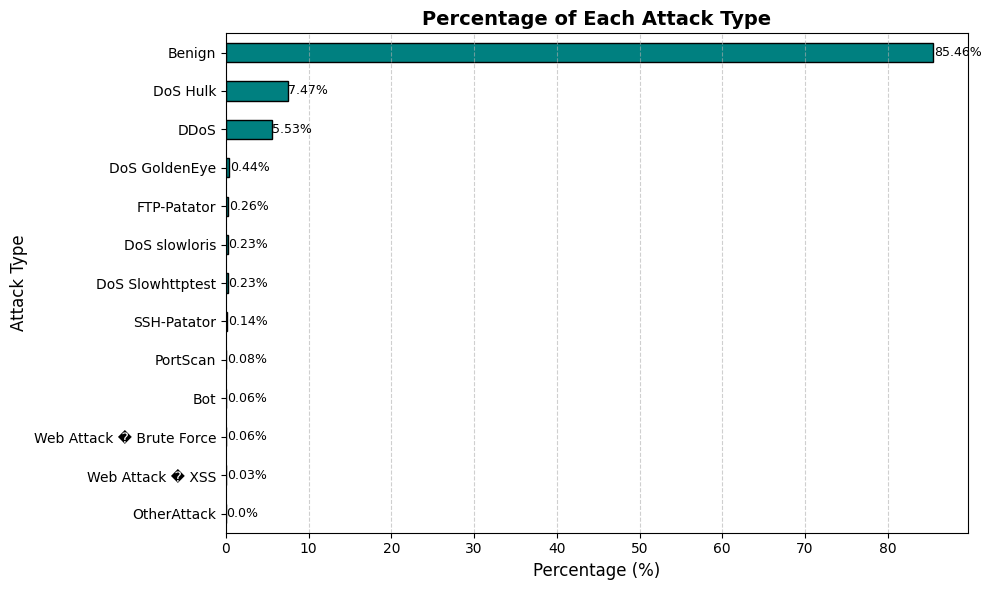

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have y (your labels)
label_percentages = (y.value_counts(normalize=True) * 100).round(2)

plt.figure(figsize=(10, 6))
label_percentages.sort_values().plot(kind='barh', color='teal', edgecolor='black')

plt.title("Percentage of Each Attack Type", fontsize=14, fontweight='bold')
plt.xlabel("Percentage (%)", fontsize=12)
plt.ylabel("Attack Type", fontsize=12)

# Add text labels next to bars
for i, (val, name) in enumerate(zip(label_percentages.sort_values().values,
                                    label_percentages.sort_values().index)):
    plt.text(val + 0.1, i, f"{val}%", va='center', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


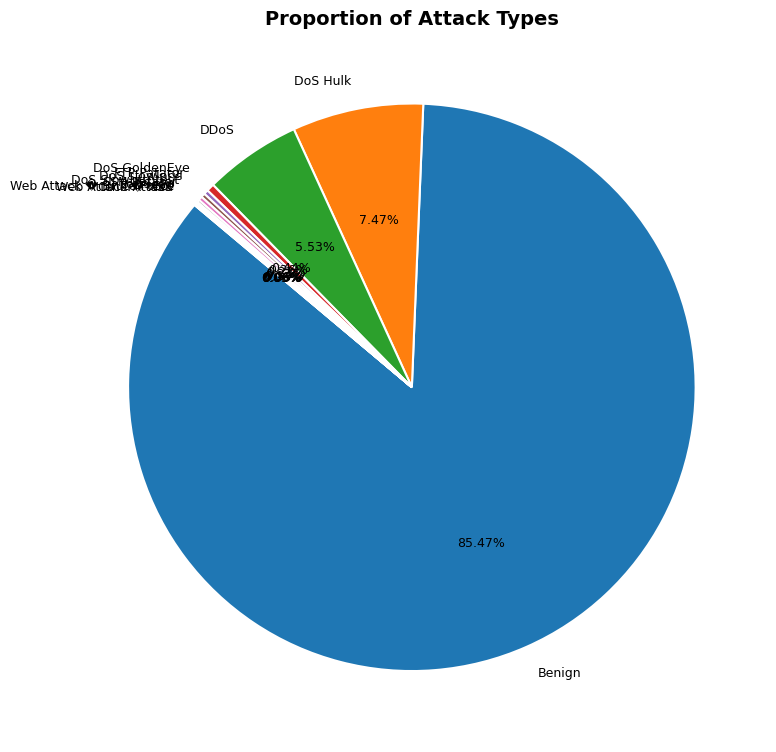

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(label_percentages,
        labels=label_percentages.index,
        autopct='%1.2f%%',
        startangle=140,
        textprops={'fontsize': 9},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})

plt.title("Proportion of Attack Types", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After cleaning & scaling:", X_scaled.shape, y_encoded.shape)
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y_encoded, test_size=0.3, random_state=42 )

After cleaning & scaling: (2313810, 77) (2313810,)


# BASELINE COMPARISON MODELS

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
np.random.seed(42)
n_samples = 1000
n_features = 80

X = np.random.rand(n_samples, n_features)
y = np.random.rand(n_samples) * 100

feature_names = [f'feat_{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

df_sample = df.sample(n=200, random_state=42)
X_sample = df_sample.drop(columns=['target']).values
y_sample = df_sample['target'].values

# train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)


In [ ]:
# train regression
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [ ]:
#Evaluate Baseline
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression on sampled data:")
print("RMSE:", rmse)
print("R² score:", r2)

Baseline Linear Regression on sampled data:
RMSE: 46.95630766445353
R² score: -1.640726761080288


# FEATURE SELECTION METHODS -1) woa

WHALE OPTIMISATION ALGO

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
def fitness_function(mask, X, y):
    if mask.sum() == 0:  # avoid empty feature subset
        return 0

    X_sel = X[:, mask == 1]

    # Check if target is continuous (regression) or discrete (classification)
    if np.issubdtype(y.dtype, np.floating):
        # Regression
        clf = LinearRegression()
        score = cross_val_score(clf, X_sel, y, cv=3, scoring='r2').mean()
    else:
        # Classification
        clf = LogisticRegression(max_iter=100, solver='liblinear')
        # Encode labels if not numeric
        if y.dtype.kind in {'U', 'S', 'O'}:
            le = LabelEncoder()
            y_enc = le.fit_transform(y)
        else:
            y_enc = y
        score = cross_val_score(clf, X_sel, y_enc, cv=3, scoring='accuracy').mean()

    return score

In [ ]:
#binary woa
def binary_woa(X_train, y_train, n_whales=10, n_iter=20):
    n_features = X_train.shape[1]
    whales = np.random.randint(0, 2, (n_whales, n_features))
    best_whale, best_fitness = whales[0].copy(), 0

    for _ in range(n_iter):
        for whale in whales:
            fitness = fitness_function(whale, X_train, y_train)
            if fitness > best_fitness:
                best_whale, best_fitness = whale.copy(), fitness

        # Update positions (binary rule)
        whales = np.where(np.random.rand(*whales.shape) < 0.5, best_whale, whales)

    return best_whale, best_fitness

In [ ]:
best_mask, best_score = binary_woa(X_train, y_train, n_whales=8, n_iter=15)
print("WOA selected features:", best_mask.sum())
print("WOA selected features:", best_mask)
print("Best fitness:", best_score)

WOA selected features: 34
WOA selected features: [1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 1]
Best fitness: 0


In [ ]:
selected_indices = feature_numbers = [
    1, 2, 5, 6, 10, 12, 13, 14, 15, 17,
    21, 22, 27, 28, 29, 31, 34, 35, 39, 41,
    44, 45, 48, 51, 52, 56, 57, 59, 60, 62,
    64, 67, 70, 71, 72, 73, 75, 77, 79
]
selected_feature_names =df.columns[selected_indices].tolist()
print("Selected feature names:", selected_feature_names)

NameError: name 'df' is not defined

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=[f'feat_{i}' for i in range(X_train.shape[1])])
X_test_df  = pd.DataFrame(X_test, columns=[f'feat_{i}' for i in range(X_test.shape[1])])

X_train_woa = X_train_df.iloc[:, selected_indices]
X_test_woa  = X_test_df.iloc[:, selected_indices]


In [ ]:
reg_woa = LinearRegression()
reg_woa.fit(X_train_woa, y_train)
y_pred_woa = reg_woa.predict(X_test_woa)

rmse_woa = np.sqrt(mean_squared_error(y_test, y_pred_woa))
r2_woa = r2_score(y_test, y_pred_woa)

print("WOA RMSE:", rmse_woa)
print("WOA R² score:", r2_woa)

WOA RMSE: 34.328935854439436
WOA R² score: -0.4114200088714517


In [ ]:
#evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_woa))

# R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred_woa)

print("WOA-selected features Regression Metrics:")
print("RMSE:", rmse)
print("R² score:", r2)

WOA-selected features Regression Metrics:
RMSE: 34.328935854439436
R² score: -0.4114200088714517


# FEATURE SELECTION METHODS-2)INFINTE FEATURE SELECTION

INFINTE FEATURE SELECTION

In [ ]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 8.3 MB/s eta 0:00:00


In [ ]:
from feature_engine.selection import MRMR

In [ ]:
pip install mrmr-selection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification

so this is not running due to the vast amount of data which has been accumulated so will just sample some data for this

In [ ]:
X, y = make_classification(n_samples=10000, n_features=80,
                           n_informative=30, n_redundant=10,
                           n_classes=5, random_state=42)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test  = scaler.transform(X1_test)
X_train_df = pd.DataFrame(X_train)
X_test_df  = pd.DataFrame(X_test)
X_train_df = pd.DataFrame(X_train)
X_test_df  = pd.DataFrame(X_test)

In [ ]:
idx_features = mrmr_classif(X=X_train_df, y=y_train, K=20)
print("Selected feature indices:", idx_features)

100%|██████████| 20/20 [00:41<00:00,  2.07s/it]

Selected feature indices: [np.int64(22), np.int64(19), np.int64(13), np.int64(70), np.int64(12), np.int64(76), np.int64(54), np.int64(73), np.int64(10), np.int64(75), np.int64(41), np.int64(18), np.int64(23), np.int64(42), np.int64(39), np.int64(52), np.int64(72), np.int64(40), np.int64(43), np.int64(17)]


In [ ]:
X_train_ifs = X_train_df[idx_features]
X_test_ifs  = X_test_df[idx_features]
print(f"✅ Selected top {len(idx_features)} features using IFS")

✅ Selected top 20 features using IFS


In [ ]:
selected_indices = [X_train_df.columns.get_loc(f) for f in idx_features]
print("Selected feature indices:", selected_indices)

Selected feature indices: [22, 19, 13, 70, 12, 76, 54, 73, 10, 75, 41, 18, 23, 42, 39, 52, 72, 40, 43, 17]


In [ ]:
selected_indices = [22, 19, 13, 70, 12, 76, 54, 73, 10, 75, 41, 18, 23, 42, 39, 52, 72, 40, 43, 17]
# actual columns names selected
selected_feature_names =df.columns[selected_indices].tolist()
print("Selected feature names:", selected_feature_names)

Selected feature names: ['Fwd IAT Std', 'Flow IAT Min', 'Bwd Packet Length Std', 'Active Std', 'Bwd Packet Length Mean', 'Idle Min', 'Avg Bwd Segment Size', 'Idle Mean', 'Bwd Packet Length Max', 'Idle Max', 'Packet Length Std', 'Flow IAT Max', 'Fwd IAT Max', 'Packet Length Variance', 'Packet Length Max', 'Avg Packet Size', 'Active Min', 'Packet Length Mean', 'FIN Flag Count', 'Flow IAT Std']


In [ ]:
X_train_selected_values = X_train_df[idx_features].values
print("Shape of selected features:", X_train_selected_values.shape)
print("First row of selected features:", X_train_selected_values[0])

Shape of selected features: (1619667, 20)
First row of selected features: [-0.21331049 -0.05901083 -0.44977134 -0.11579926 -0.50084368 -0.37982705
 -0.50084368 -0.39472443 -0.48319581 -0.40042908 -0.4944919  -0.28846196
 -0.28108772 -0.32894948 -0.50789701 -0.55190093 -0.11185984 -0.54127255
 -0.18396605 -0.22810544]


APPLY MODEL HERE AND COMPARE TO REGULAR BASELINE MODEL OF SOME SAMPLE

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
import numpy as np

RANODM FOREST CLASSIFIER

LINEAR REGRESSION

In [ ]:
#  Linear Regression
y_train_reg = y_train.astype(float)
y_test_reg = y_test.astype(float)


In [ ]:
reg = LinearRegression()
reg.fit(X_train_ifs, y_train_reg)

LinearRegression()

In [ ]:
y_pred_reg = reg.predict(X_test_ifs)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nLinear Regression:")
print("RMSE:", rmse)
print("R² score:", r2)


Linear Regression:
RMSE: 0.9535910456716867
R² score: 0.4949483695032719
